In [44]:
#required libraries : 
import pandas as pd
import numpy as np
import glob, os  # dealing with OS and Files, reading files etc 
from IPython.display import HTML, display
import tabulate
import seaborn as sns 
import missingno as msno
import matplotlib.pyplot as plt 
import pandas as pd  # dataframe structure
from pandas import Series
from pandas import DataFrame
import numpy as np  # array structure
import seaborn as sns # visualization
import matplotlib.pyplot as plt # plot
import pickle # saving model, data, etc : serialization
from sklearn.metrics import mean_squared_error
from math import sqrt
import time
import datetime
import scipy
import itertools
import warnings
warnings.filterwarnings("ignore")  #ignore warning
%matplotlib inline

# Risque de fréquence d'accidents et le risk de gravité associé 

### Problématique : 

Dans ce notebook nous allons nous intéresser à étudier seulement l'impact de la configuration ou la description d'un lieu d'accident sur la fréquence et la gravité des accidents. 

Donc les objectifs sont :
    1. de pouvoir élaborer un risque de fréquence d'accidents  en fonction d'une configuration donnée du lieu d'accident
    2. de pouvoir élaborer un risque de gravité d'accidents en fonction d'une configuration donnée du lieu d'accident
    
L'ONSR peut déployer cette solution dans le but de prédire les risques associés à un nouvel aménagement ou trouver les configurations avec plus d'accidents et les aménager.

### Formalisation en Data Mining : 

#### Contraintes :

Avant de commencer la traduction de la problématique en problème fouille de données, nous devons d'abord définir la variable cible. Pour cela nous allons créer lors de la phase de préparation des données deux variables :
    1. Une variable qui va considérer le nombre d'accidents par configuration de route, puis discrétiser cette variable en deux niveaux
    2. Une variable qui va considérer la  gravité des personnes impliqueés par configuration de route, puis discrétiser cette variable en deux niveaux

#### Formalisation:

Objectif 1 : Un modèle de classification -en utilisant les données à disposition- afin de calculer le risque associé à une configuration d'une route donnée.

Objectif 2 : Un modèle de classification -en utilisant les données à disposition- afin de calculer le risque de gravité d'une route donnée.

# Méthode de travail : 

La méthode qui sera utilisé tout au long du projet est la méthode la plus populaire CRISP-DM dont le cycle de vie est présenté ci-dessus : 

![](crisp.PNG)

Vu que nos objectifs nécessaitent les mêmes données, la même préparation et le même nettoyage nous allons suivre la méthode CRISP-DM pour les deux objectifs parallèlement. Avant de se lancer dans la compréhension du marché, nous allons élaborer d'abord notre plan de projet : 

In [30]:
table=[["Phase",	"Temps","Ressources","Risques"],
       ["Compréhension du problème", "1 semaine","tout le groupe","Changement économique"],
["Compréhension des données","1 semaines","tout le groupe", "Problèmes de données, problèmes technologiques"],
       ["Préparation des données","3 semaines","tout le groupe","Problèmes de données, problèmes technologiques"],
["Modélisation" ,"1 semaines", "tout le groupe","Problèmes technologiques, incapacité à trouver un modèle adéquat"],
["Evaluation", "1 semaine", "Encadrants, Hugo DARCHIS et Edouard LE COZ", "incapacité à mettre en oeuvre les résultats"],
["Déploiement","1 semaine"," Riahi LOURIZ","Changement économique, incapacité à mettre en oeuvre les résultats"]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Phase,Temps,Ressources,Risques
Compréhension du problème,1 semaine,tout le groupe,Changement économique
Compréhension des données,1 semaines,tout le groupe,"Problèmes de données, problèmes technologiques"
Préparation des données,3 semaines,tout le groupe,"Problèmes de données, problèmes technologiques"
Modélisation,1 semaines,tout le groupe,"Problèmes technologiques, incapacité à trouver un modèle adéquat"
Evaluation,1 semaine,"Encadrants, Hugo DARCHIS et Edouard LE COZ",incapacité à mettre en oeuvre les résultats
Déploiement,1 semaine,Riahi LOURIZ,"Changement économique, incapacité à mettre en oeuvre les résultats"


### Compréhension du marché 

reste à faire....

### Compréhension des données 


Cette implique l'étude des données à disposition sur les accidents corporels en France. Cette étape a un poids important dans la méthode CRISP-DM car elle permet d'éviter les problèmes inattendues au cours de la phase de la préparation des données. Pour bien amener cette étape, nous allons suivre les étapes suivantes : 

##### A : Collecte des données initiales: 

###### Sources des données :

Les données utilisées afin de répondre à nos problématiques ont été collectées depuis la plateforme ouvertes des données publiques françaises (Datagov). Ces données sont saisies et rassemblées dans une fiche intitulée bulletin d’analyse des accidents corporels. L’ensemble de ces fiches forme le fichier national des accidents corporels de la circulation dit Fichier BAAC administré par l’Observatoire national interministériel de la sécurité routière (ONISR).
Les données sont fournies pour chaque année ( de 2005 à 2016) sous forme de
quatre tables :

1. La table <b>CARACTERISTIQUES</b> qui décrit les circonstances générales de
l’accident
2. La table <b>LIEUX</b> qui décrit le lieu principal de l’accident même si celui-ci s’est déroulé à une Intersection
3. La table <b>VEHICULES</b> impliqués
4. La table <b>USAGERS</b> impliqués

Pour la définition des attributs de chaque table voir document PDF.

###### Attributs prometteurs : 

En se basant sur l'objectif fixé au début du notebook, nous allons lister les variables les plus intérresantes pour mener le reste de l'étude. Vu qu'on est intéressé sur l'impact de la configuration ou la description d'une route sur la fréquence et la gravité des accidents, alors nous allons choisir les variables suivantes (pour la siginification des variables veuillez référer au document PDF): 

In [15]:
col_used=['lum', 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp','prof', 'plan', 'lartpc','larrout', 'infra','situ', 'obs','obsm']

###### Fusion des données :

Les quatres tables  pour la période (2005-2016) doivent être rassemblés sur quatres tables : 
1. La table <b>CARACTERISTIQUES</b> sur toute la période 2005-2016
2. La table <b>LIEUX</b>  sur toute la période 2005-2016
3. La table <b>VEHICULES</b>  sur toute la période 2005-2016
4. La table <b>USAGERS</b>  sur toute la période 2005-2016

In [18]:
path =r'dataset/caracteristiques' # path containing all csv files about caracteristiques (  use your own path)
allFiles = glob.glob(path + "/*.csv")  # a list containing files names (all csv files)
list_ = []
for file_ in allFiles:
    if '2009' in file_ :
        df = pd.read_table(file_,encoding='latin-1') # read table file (file_) for year 2009
        list_.append(df)  # append the the dataframe df to the lust list_
    else : 
        df = pd.read_csv(file_,encoding='latin-1') # read csv file (file_)
        list_.append(df)  # append the the dataframe df to the lust list_     
        
caracteristiques = pd.concat(list_)  # concat all dataframes existing in list_

In [19]:
path =r'dataset/usagers' 
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,encoding='latin-1')
    list_.append(df)
usagers = pd.concat(list_)

In [20]:
path =r'dataset/lieux' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,encoding='latin-1')
    list_.append(df)
lieux = pd.concat(list_)

In [21]:
path =r'dataset/vehicules' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,encoding='latin-1')
    list_.append(df)
vehicules = pd.concat(list_)

###### Taille de données et contrainte pour les problématiques: 

La base de données contient un historique à partir de 2005 jusqu'au 2016, par conséquente on a suffisamment des données pour traiter nos problématiques

##### B. Description des données

Il exist plusieurs méthodes pour décrire les données, mais la plupart des descriptions sont axées sur la quantité et la qualité des données : le volume de données disponibles et l'état de ces données.

###### Quantité de données:

In [27]:
# memory size for each table : 
print("Info abour caracteristiques : ")
caracteristiques.info()
print("----------------------------------------------------------")
print("----------------------------------------------------------")
print("Info abour lieux :") 
lieux.info()
print("----------------------------------------------------------")
print("----------------------------------------------------------")
print("Info abour vehicules :")
vehicules.info()
print("----------------------------------------------------------")
print("----------------------------------------------------------")
print("Info abour usagers :") 
usagers.info()


Info abour caracteristiques : 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 839985 entries, 0 to 59431
Data columns (total 16 columns):
Num_Acc    839985 non-null int64
an         839985 non-null int64
mois       839985 non-null int64
jour       839985 non-null int64
hrmn       839985 non-null int64
lum        839985 non-null int64
agg        839985 non-null int64
int        839985 non-null int64
atm        839930 non-null float64
col        839974 non-null float64
com        839983 non-null float64
adr        699443 non-null object
gps        366226 non-null object
lat        362471 non-null float64
long       362467 non-null object
dep        839985 non-null int64
dtypes: float64(4), int64(9), object(3)
memory usage: 108.9+ MB
----------------------------------------------------------
----------------------------------------------------------
Info abour lieux :
<class 'pandas.core.frame.DataFrame'>
Int64Index: 839985 entries, 0 to 59431
Data columns (total 18 columns):
Num_Acc  

In [29]:
print("-----------Shape of our dataframes ---------------")
print("The shape of caracteristiques is :", caracteristiques.shape)
print("The shape of lieux is :", lieux.shape)
print("The shape of vehicules is :", vehicules.shape)
print("The shape of usagers is :", usagers.shape)
print("Total Missing Data (note that 0 means also a nan value but should be converted to nan later during cleaning stage)")
print("Total missing data in  caracteristiques is :", caracteristiques.isnull().sum().sum())
print("Total missing data in  lieux is :", lieux.isnull().sum().sum())
print("Total missing data in  vehicules is :", vehicules.isnull().sum().sum())
print("Total missing data in  usagers is :", usagers.isnull().sum().sum())

-----------Shape of our dataframes ---------------
The shape of caracteristiques is : (839985, 16)
The shape of lieux is : (839985, 18)
The shape of vehicules is : (1433389, 9)
The shape of usagers is : (1876005, 12)
Count Missing Data (note that 0 means also a nan value but should be converted to nan later during cleaning stage)
Total missing data in  caracteristiques is : 1569401
Total missing data in  lieux is : 2250933
Total missing data in  vehicules is : 1970
Total missing data in  usagers is : 151687


###### Types de valeur : 

D'après la partie ci-dessus, nous remarquons très bien variables se présente sous un seul type, à savoir : numérique.

Certes ce type n'est pas le seul présenté dans notre jeu de données car on a beaucoup de variables catégorielles  codées numériquement avec des entiers.



###### Méthode de codage :

la partie ci-dessus nous permet déjà de penser aux types de codage qui sera utilisé par la suite lors de la modélisation, soit on garde ce codage ou on va utiliser le <b>Hot encoding</b>

##### C. Vérification de la qualité des données : 

Les données sont rarement présentées bien nettoyées. En fait, les données généralement contiennent des valeurs manquantes, des points aberrants, des erreurs de saisie etc. Le document définissant la base de données mentionne avec toute clarté qu'il aie des valeurs manquantes : "La plupart des variables contenues dans les quatre fichiers précédemment énumérés peuvent contenir
des cellules vides ou un zéro ou un point. Il s’agit, dans ces trois cas, d’une cellule non renseignée par
les forces de l'ordre ou sans objet"

Nous n'allons pas nettoyer les données à ce stade, mais cela sera une partie dans la préparation des données.

##### D. Exploration des données : 

Utiliser tableau pour visualiser les données ou simplement faire des table croisé ....

### Préparation des données


D'après l'effort qui a été consacré aux étapes précédentes, nous allons lister les principales tâches à faire lors de la préparation des données : 

- Fusion des quatres tables 
- Aggrégation des lignes selon les colonnes choisie pour la définition de la configuration d'une route.

Les colonnes aggrégées sont : 
    1. Num_Acc (opération d'aggrégation est <b> count </b>) 
    2. grav (opération d'aggrégation est <b> value_counts</b>)
    
- Traitement des valeurs manquantes
- Traitement des outliers
- Feature engineering :  création de deux variables cibles qui vont mesurer le risk de fréquence d'accident et le score de gravité pour chaque configuration du lieu d'accident.
- Fractionnement du jeu de données en train/test data

###### Fusion des quatres tables : 

In [31]:
# on merge caracteristiques et lieux puis on merge avec vehicules : 
carac_lieux_veh_merged=pd.merge(pd.merge(caracteristiques,lieux,on='Num_Acc'), vehicules,on='Num_Acc' )
#on merge finalement avec usagers :
data_merged=pd.merge(carac_lieux_veh_merged,usagers,on=['Num_Acc','num_veh'])

In [39]:
# show first and last 3 rows : 
data_merged.head(3)

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,...,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais
0,200500000001,5,1,12,1900,3,2,1,1.0,3.0,...,1.0,1,4,1,1.0,11.0,0.0,0.0,0.0,1976.0
1,200500000001,5,1,12,1900,3,2,1,1.0,3.0,...,1.0,1,3,2,3.0,11.0,0.0,0.0,0.0,1968.0
2,200500000001,5,1,12,1900,3,2,1,1.0,3.0,...,2.0,2,1,1,0.0,11.0,0.0,0.0,0.0,1964.0


In [38]:
data_merged.tail(3)

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,...,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais
1875980,201600059432,16,12,24,635,1,2,6,1.0,3.0,...,1.0,1,4,1,3.0,21.0,0.0,0.0,0.0,1967.0
1875981,201600059432,16,12,24,635,1,2,6,1.0,3.0,...,2.0,2,4,1,0.0,21.0,0.0,0.0,0.0,1967.0
1875982,201600059432,16,12,24,635,1,2,6,1.0,3.0,...,1.0,1,1,1,0.0,11.0,0.0,0.0,0.0,1981.0


In [41]:
#save data_merged to csv file : 
data_merged.to_csv('score-analysis/data_merged.csv', index=False)

###### Traitement des valeurs manquantes : 

Nous n'allons imputer que les variables qui nous intéresse qui sont définie dans la liste <b>col_used</b>

In [43]:
#rappel : 
print(col_used)

['lum', 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'lartpc', 'larrout', 'infra', 'situ', 'obs', 'obsm']


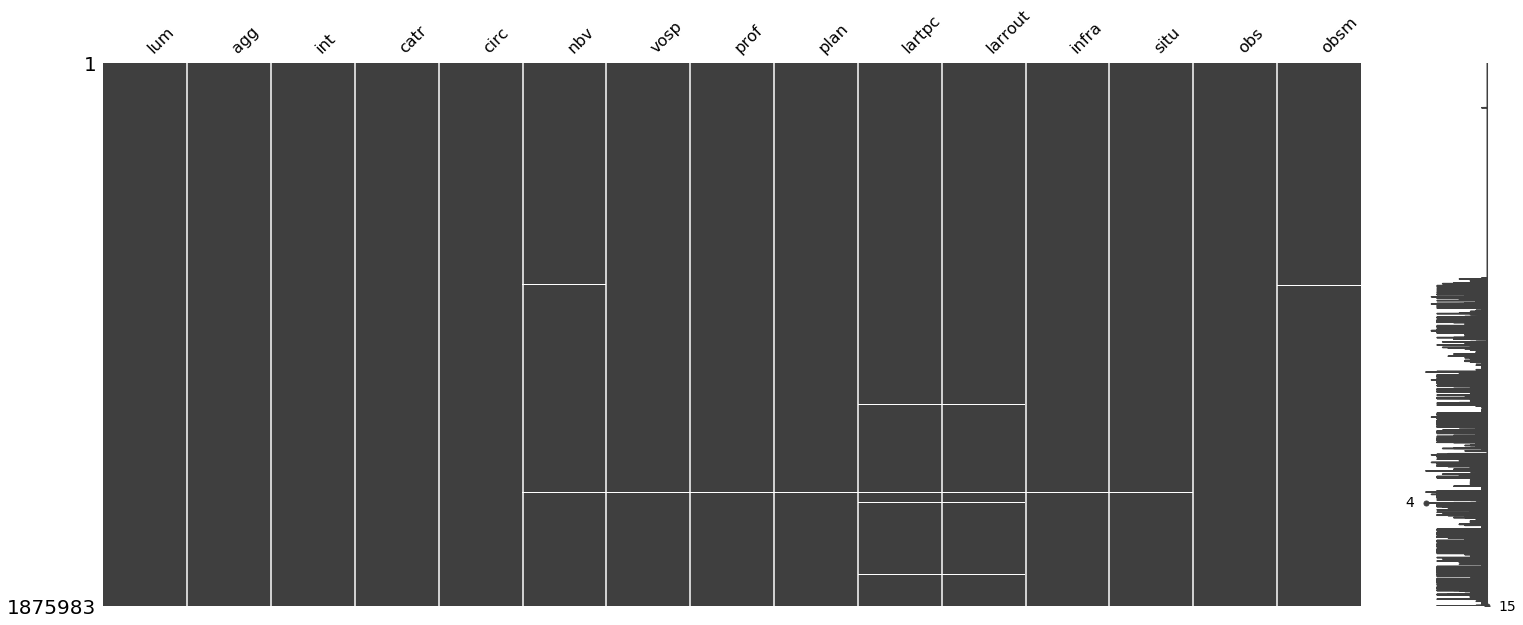

In [45]:
#visualisatio des valeurs manquantes : A noter on considére que nan
msno.matrix(data_merged.loc[:,col_used])

In [46]:
#détail du nombre de valeurs manquantes par colonnes
data_merged.loc[:,col_used].isnull().sum()

lum            0
agg            0
int            0
catr           2
circ        1781
nbv         4063
vosp        3769
prof        2399
plan        2443
lartpc     21272
larrout    18297
infra       2899
situ        2278
obs          790
obsm         677
dtype: int64

Traiter les valeurs maquantes revient à savoir les mécanismes dérier (MAR, MCAR, MNAR)

Une carte de chaleur de corrélation (<b>heatmap correlation</b> simple est montrée ci-dessous. Cette carte décrit le degré de relation de nullité entre les différentes caractéristiques. La plage de cette corrélation de nullité va de -1 à 1 (-1 ≤ R ≤ 1). Les variables sans valeur manquante sont exclues du heatmap. Si la corrélation de nullité est très proche de zéro (-0,05 <R <0,05) (par exemple: catr vs catr), aucune valeur ne sera affichée. En outre, une corrélation de nullité positive parfaite (R = 1) indique que la première variable et la deuxième variable ont toutes les deux des valeurs manquantes correspondantes (MAR) alors qu'une corrélation de nullité négative parfaite (R = -1) signifie que l'une des variables est manquante alors que  la seconde ne l'est pas (MNAR).

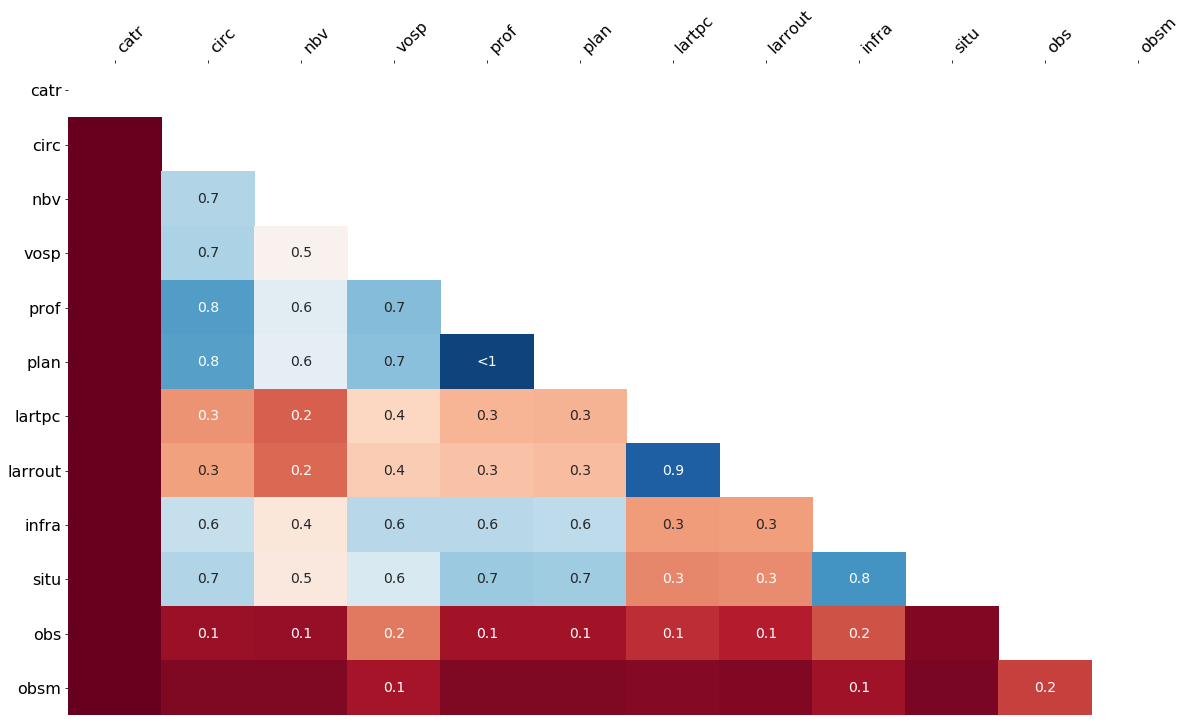

In [47]:
msno.heatmap(data_merged.loc[:,col_used])


Le heatmap nous permet de conclure quant à la méthode d'imputation qui doit être utilisée. Cette méthode ne doit pas être stationnaire (imputation par le mode (variables catégorielles) ou la moyenne (variables numériques) car on n'est pas face à un phénomène MCAR, et donc une supression des lignes correspondant aux valeurs manquantes baisera les résultats.

Cependant les données présentent des variables de différents types et les méthodes qui sont utilisées pour l'imputation des valeurs manquantes gérent mieux que les valeurs numériques comme <b>fancyimpute</b> et <b>MICE</b> (Multiple Imputation by Chained Equations)

Par conséquent nous allons opter pour un algorithme qui traitent les valeurs manquantes d'une façon interne. On va choisir <b>xgboost</b> qui traitent les valeurs manquantes d'une telle façon à minimiser la fonction de coût qui lui est propore.

Ceci nous finit pas cette partie, car dans le jeu de données il n'a pas que des nan qui impliquent une valeur manquantes mais aussi des 0 ou enore des cases vides.

In [50]:
print(col_used)

['lum', 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'lartpc', 'larrout', 'infra', 'situ', 'obs', 'obsm']


<mark>lum</mark> : 

In [51]:
print(data_merged.lum.unique())
# ok

[3 1 5 4 2]


<mark>agg</mark> : 

In [52]:
print((data_merged['agg'].unique()))
#ok

[2 1]


<mark>intersection</mark> :

In [53]:
print((data_merged.int.unique()))
#replace 0  with nan

[1 2 9 0 6 8 3 4 7 5]


In [54]:
data_merged.loc[:,'int']=data_merged.loc[:,'int'].replace(0,np.nan)

<mark>catr</mark> :

In [55]:
print(data_merged['catr'].unique())
#ok

[  3.   2.   4.   6.   9.   5.   1.  nan]


###### Aggrégation

### Modélisation


### Evaluation

### Déploiment

### Required libraries :

In [4]:
df=pd.read_csv('data-without-imputing-all-years/data_merged-2005-2016.csv', encoding='latin')

C:\Users\rlouriz\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [62]:
res1=df.groupby(['lum', 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp','prof', 'plan', 'lartpc','larrout', 'infra','situ', 'obs','obsm']).grav.value_counts()

In [66]:
data = res1.rename(columns={'grav': 'nb_grav'})

In [68]:
data=data.reset_index()

In [70]:
data.shape

(376361, 17)

In [72]:
data['indemne']=0  # 1
data['tue']=0  # 2 
data['hospitalisé']=0  # 3
data['blessé']=0  # 4 

In [76]:
data.columns

Index([        'lum',         'agg',         'int',        'catr',
              'circ',         'nbv',        'vosp',        'prof',
              'plan',      'lartpc',     'larrout',       'infra',
              'situ',         'obs',        'obsm',        'grav',
                   0,     'indemne',         'tue', 'hospitalisé',
            'blessé'],
      dtype='object')

In [78]:
data=data.rename(columns={0:'nb_grav'})

In [124]:
list(data.columns)
    

['lum',
 'agg',
 'int',
 'catr',
 'circ',
 'nbv',
 'vosp',
 'prof',
 'plan',
 'lartpc',
 'larrout',
 'infra',
 'situ',
 'obs',
 'obsm',
 'grav',
 'nb_grav',
 'indemne',
 'tue',
 'hospitalisé',
 'blessé']

In [82]:
for i in range(data.shape[0]):
    if data.loc[i,'grav']==1 :
        data.loc[i,'indemne']=data.loc[i,'nb_grav']
    elif data.loc[i,'grav']==2 :
        data.loc[i,'tue']=data.loc[i,'nb_grav']
    elif data.loc[i,'grav']==3 :
        data.loc[i,'hospitalisé']=data.loc[i,'nb_grav']
    else :
        data.loc[i,'blessé']=data.loc[i,'nb_grav']
        

In [83]:
data.to_csv('data_risk.csv',index=False)

In [84]:
data.head()

,lum,agg,int,catr,circ,nbv,vosp,prof,plan,lartpc,...,infra,situ,obs,obsm,grav,nb_grav,indemne,tue,hospitalisé,blessé
0,1,1,0,3.0,3.0,2.0,0.0,1.0,1.0,50.0,...,3.0,1.0,0.0,2.0,1,1,1,0,0,0
1,1,1,0,3.0,3.0,2.0,0.0,1.0,1.0,50.0,...,3.0,1.0,0.0,2.0,3,1,0,0,1,0
2,1,1,0,4.0,1.0,2.0,0.0,2.0,3.0,0.0,...,0.0,1.0,0.0,1.0,1,1,1,0,0,0
3,1,1,0,4.0,1.0,2.0,0.0,2.0,3.0,0.0,...,0.0,1.0,0.0,1.0,3,1,0,0,1,0
4,1,1,0,4.0,1.0,2.0,0.0,2.0,3.0,0.0,...,0.0,1.0,0.0,2.0,1,1,1,0,0,0


In [116]:
res2=data.groupby(['lum', 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp','prof', 'plan', 'lartpc',
                   'larrout', 'infra','situ', 'obs','obsm']).agg({'indemne':['sum'],'tue':['sum'],
                                                                  'hospitalisé':['sum'],'blessé':['sum']})

In [117]:
res2=res2.reset_index()

In [118]:
type(res2)

pandas.core.frame.DataFrame

In [108]:
res2.head()

,lum,agg,int,catr,circ,nbv,vosp,prof,plan,lartpc,larrout,infra,situ,obs,obsm,indemne,tue,hospitalisé,blessé
,,,,,,,,,,,,,,,,sum,sum,sum,sum
0,1,1,0,3.0,3.0,2.0,0.0,1.0,1.0,50.0,40.0,3.0,1.0,0.0,2.0,1,0,1,0
1,1,1,0,4.0,1.0,2.0,0.0,2.0,3.0,0.0,60.0,0.0,1.0,0.0,1.0,1,0,1,0
2,1,1,0,4.0,1.0,2.0,0.0,2.0,3.0,0.0,60.0,0.0,1.0,0.0,2.0,1,0,0,0
3,1,1,1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,42,0,5,29
4,1,1,1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,9.0,0,0,0,1


In [120]:
for ele in list(res2.columns):
    print(ele)

('lum', '')
('agg', '')
('int', '')
('catr', '')
('circ', '')
('nbv', '')
('vosp', '')
('prof', '')
('plan', '')
('lartpc', '')
('larrout', '')
('infra', '')
('situ', '')
('obs', '')
('obsm', '')
('indemne', 'sum')
('tue', 'sum')
('hospitalisé', 'sum')
('blessé', 'sum')


In [126]:
col_names=['lum','agg','int','catr','circ', 'nbv', 'vosp', 'prof','plan','lartpc','larrout',
 'infra','situ', 'obs','obsm','indemne','tue','hospitalisé','blessé']
res2.columns=col_names

In [127]:
res2.head()

,lum,agg,int,catr,circ,nbv,vosp,prof,plan,lartpc,larrout,infra,situ,obs,obsm,indemne,tue,hospitalisé,blessé
0,1,1,0,3.0,3.0,2.0,0.0,1.0,1.0,50.0,40.0,3.0,1.0,0.0,2.0,1,0,1,0
1,1,1,0,4.0,1.0,2.0,0.0,2.0,3.0,0.0,60.0,0.0,1.0,0.0,1.0,1,0,1,0
2,1,1,0,4.0,1.0,2.0,0.0,2.0,3.0,0.0,60.0,0.0,1.0,0.0,2.0,1,0,0,0
3,1,1,1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,42,0,5,29
4,1,1,1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,9.0,0,0,0,1


In [128]:
res2.columns

Index(['lum', 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'plan',
       'lartpc', 'larrout', 'infra', 'situ', 'obs', 'obsm', 'indemne', 'tue',
       'hospitalisé', 'blessé'],
      dtype='object')

In [129]:
res2.shape

(200398, 19)

In [130]:
res2.to_csv('data_prepared_risk.csv',index=False)

In [131]:
df.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,...,actp,etatp,an_nais,age,date,day_of_week,day_of_week_encoded,nuit,heure_pointe,fatigue
0,200500000001,2005,1,12,19:00,3,2,1,1.0,3.0,...,0.0,0.0,1976.0,29.0,2005-01-12,Wednesday,6,1,1,0
1,200500000001,2005,1,12,19:00,3,2,1,1.0,3.0,...,0.0,0.0,1968.0,37.0,2005-01-12,Wednesday,6,1,1,0
2,200500000001,2005,1,12,19:00,3,2,1,1.0,3.0,...,0.0,0.0,1964.0,41.0,2005-01-12,Wednesday,6,1,1,0
3,200500000001,2005,1,12,19:00,3,2,1,1.0,3.0,...,0.0,0.0,2004.0,1.0,2005-01-12,Wednesday,6,1,1,0
4,200500000001,2005,1,12,19:00,3,2,1,1.0,3.0,...,0.0,0.0,1998.0,7.0,2005-01-12,Wednesday,6,1,1,0


In [132]:
res3=df.groupby(['lum', 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp','prof', 'plan', 'lartpc',
                   'larrout', 'infra','situ', 'obs','obsm']).agg({'Num_Acc':['count']})

In [133]:
res3.shape

(200398, 1)

In [135]:
res3=res3.reset_index()

In [137]:
res3.head()

,lum,agg,int,catr,circ,nbv,vosp,prof,plan,lartpc,larrout,infra,situ,obs,obsm,Num_Acc
,,,,,,,,,,,,,,,,count
0,1,1,0,3.0,3.0,2.0,0.0,1.0,1.0,50.0,40.0,3.0,1.0,0.0,2.0,2
1,1,1,0,4.0,1.0,2.0,0.0,2.0,3.0,0.0,60.0,0.0,1.0,0.0,1.0,2
2,1,1,0,4.0,1.0,2.0,0.0,2.0,3.0,0.0,60.0,0.0,1.0,0.0,2.0,1
3,1,1,1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,76
4,1,1,1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,9.0,1


In [138]:
col_names2=['lum','agg','int','catr','circ', 'nbv', 'vosp', 'prof','plan','lartpc','larrout',
 'infra','situ', 'obs','obsm','nb_acc']
res3.columns=col_names2

In [143]:
res3.head()

,lum,agg,int,catr,circ,nbv,vosp,prof,plan,lartpc,larrout,infra,situ,obs,obsm,nb_acc
0,1,1,0,3.0,3.0,2.0,0.0,1.0,1.0,50.0,40.0,3.0,1.0,0.0,2.0,2
1,1,1,0,4.0,1.0,2.0,0.0,2.0,3.0,0.0,60.0,0.0,1.0,0.0,1.0,2
2,1,1,0,4.0,1.0,2.0,0.0,2.0,3.0,0.0,60.0,0.0,1.0,0.0,2.0,1
3,1,1,1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,76
4,1,1,1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,9.0,1


In [156]:
res2.head()

,lum,agg,int,catr,circ,nbv,vosp,prof,plan,lartpc,...,infra,situ,obs,obsm,indemne,tue,hospitalisé,blessé,nb_acc,sc_acc
0,1,1,0,3.0,3.0,2.0,0.0,1.0,1.0,50.0,...,3.0,1.0,0.0,2.0,1,0,1,0,2,16.778112
1,1,1,0,4.0,1.0,2.0,0.0,2.0,3.0,0.0,...,0.0,1.0,0.0,1.0,1,0,1,0,2,16.778112
2,1,1,0,4.0,1.0,2.0,0.0,2.0,3.0,0.0,...,0.0,1.0,0.0,2.0,1,0,0,0,1,1.000000
3,1,1,1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,2.0,42,0,5,29,76,11990.934468
4,1,1,1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,9.0,0,0,0,1,1,2.718282


In [152]:
res2['nb_acc'] = res3['nb_acc']

In [211]:
res2['sc_acc'] =(res2.nb_acc-res2.nb_acc.min())/(res2.nb_acc.max()-res2.nb_acc.min())

res2['sc_grav'] =( res2['indemne'] + (res2['blessé'] * np.exp(1)) +
                                   (res2['hospitalisé'] * np.exp(2)) + (res2['tue'] * np.exp(3)))

In [232]:
res2['sc_grav_norm']=(res2.sc_grav)/(res2.sc_grav.max())

In [233]:
res2.sc_grav_norm.describe()

count    200398.000000
mean          0.000449
std           0.004456
min           0.000024
25%           0.000089
50%           0.000176
75%           0.000265
max           1.000000
Name: sc_grav_norm, dtype: float64

In [234]:
res2['risk']=1

In [236]:
res2.loc[((res2['sc_grav_norm']<res2.sc_grav_norm.describe()['50%'])),'risk']=1
res2.loc[((res2['sc_grav_norm']>res2.sc_grav_norm.describe()['50%'])),'risk']=2

In [244]:
res2['risk_frequence']=1

In [245]:
res2.loc[((res2['sc_acc']<res2.sc_acc.describe()['50%'])),'risk_frequence']=1
res2.loc[((res2['sc_acc']>res2.sc_acc.describe()['50%'])),'risk_frequence']=2

In [246]:
res2.head()

,lum,agg,int,catr,circ,nbv,vosp,prof,plan,lartpc,...,indemne,tue,hospitalisé,blessé,nb_acc,sc_acc,sc_grav,sc_grav_norm,risk,risk_frequence
0,1,1,0,3.0,3.0,2.0,0.0,1.0,1.0,50.0,...,1,0,1,0,2,0.000057,8.389056,0.000200,2,1
1,1,1,0,4.0,1.0,2.0,0.0,2.0,3.0,0.0,...,1,0,1,0,2,0.000057,8.389056,0.000200,2,1
2,1,1,0,4.0,1.0,2.0,0.0,2.0,3.0,0.0,...,1,0,0,0,1,0.000000,1.000000,0.000024,1,1
3,1,1,1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,42,0,5,29,76,0.004312,157.775454,0.003759,2,2
4,1,1,1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,1,1,0.000000,2.718282,0.000065,1,1


In [239]:
res2.risk.value_counts()

1    105952
2     94446
Name: risk, dtype: int64

In [243]:
res2.sc_acc.describe()

count    200398.000000
mean          0.000288
std           0.003969
min           0.000000
25%           0.000057
50%           0.000057
75%           0.000115
max           1.000000
Name: sc_acc, dtype: float64

## XGBOOSt for classification :

In [202]:
import pandas as pd  # dataframe structure
import numpy as np  # array structure
import seaborn as sns # visualization
import matplotlib.pyplot as plt # plot
import glob, os  # dealing with OS and Files, reading files etc 
import time
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, explained_variance_score
from xgboost import plot_importance

Accuracy on train set : 66.68%
Accuracy on test set : 66.64%
Confusion matrix : 
  [[22505  9147]
 [10907 17561]]
Classification report : 
               precision    recall  f1-score   support

          1       0.67      0.71      0.69     31652
          2       0.66      0.62      0.64     28468

avg / total       0.67      0.67      0.67     60120



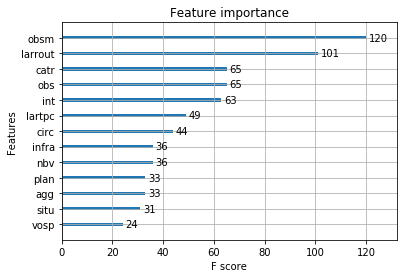

My program took 2.7353057861328125  (s) to run


In [242]:
import time
start_time = time.time()

col_used =[ 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp',  'plan', 'lartpc', 'larrout', 'infra', 'situ', 'obs', 
           'obsm', 'risk']
data=res2.loc[:,col_used]

#DataFrame.dtypes for data must be int, float or bool. So we do not perform any changing for dtypes

# split data into target and feature data :
y=data.risk.values  # target column
X=data.loc[:,data.columns!='risk']  # feature data

#split data into train/test data :
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

#fit model on training set

xgboost_model=XGBClassifier(n_jobs=-1,max_depth=3) # n_jobs=-1 to use all threads available
xgboost_model.fit(X_train,y_train)

#evaluate on train set to assist overfitting : 
y_pred_train=xgboost_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
   
#predict on test set :
y_pred_test=xgboost_model.predict(X_test)
cm=confusion_matrix(y_test,y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
#print results : 
print("Accuracy on train set : %.2f%%" % (accuracy_train * 100.0))
print("Accuracy on test set : %.2f%%" % (accuracy_test * 100.0))
print("Confusion matrix : \n ",cm)
print('Classification report : \n ',classification_report(y_test,y_pred_test))
plot_importance(xgboost_model)
plt.show()

#print time token for running the script
print("My program took", time.time() - start_time, " (s) to run")

Accuracy on train set : 68.87%
Accuracy on test set : 68.67%
Confusion matrix : 
  [[34790  3528]
 [15309  6493]]
Classification report : 
               precision    recall  f1-score   support

          1       0.69      0.91      0.79     38318
          2       0.65      0.30      0.41     21802

avg / total       0.68      0.69      0.65     60120



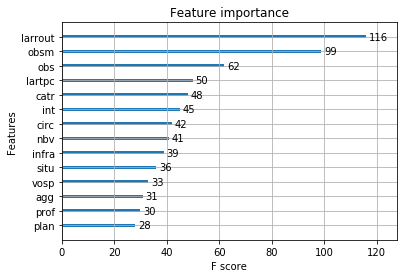

My program took 3.1804606914520264  (s) to run


In [251]:
import time
start_time = time.time()

col_used =[ 'agg', 'int', 'catr', 'circ', 'nbv', 'vosp',  'plan', 'lartpc','larrout', 'infra', 'situ', 'obs', 
           'obsm','prof','atm', 'risk_frequence']
data=res2.loc[:,col_used]

#DataFrame.dtypes for data must be int, float or bool. So we do not perform any changing for dtypes

# split data into target and feature data :
y=data.risk_frequence.values  # target column
X=data.loc[:,data.columns!='risk_frequence']  # feature data

#split data into train/test data :
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

#fit model on training set

xgboost_model=XGBClassifier(n_jobs=-1,max_depth=3) # n_jobs=-1 to use all threads available
xgboost_model.fit(X_train,y_train)

#evaluate on train set to assist overfitting : 
y_pred_train=xgboost_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
   
#predict on test set :
y_pred_test=xgboost_model.predict(X_test)
cm=confusion_matrix(y_test,y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
#print results : 
print("Accuracy on train set : %.2f%%" % (accuracy_train * 100.0))
print("Accuracy on test set : %.2f%%" % (accuracy_test * 100.0))
print("Confusion matrix : \n ",cm)
print('Classification report : \n ',classification_report(y_test,y_pred_test))
plot_importance(xgboost_model)
plt.show()

#print time token for running the script
print("My program took", time.time() - start_time, " (s) to run")